<a href="https://colab.research.google.com/github/beinghorizontal/Quantext/blob/main/lstm_options_lag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# !pip install yfinance
# !pip install pandas_ta
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install keras==3.0.0

# Import essential libraries

In [2]:
from preprocess_options_colab import get_options
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
import torch
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model

# Get option chain data from preprocess_options.py

In [ ]:
optionslist = get_options()

df = optionslist[0]

# Download the historical data from Yahoo finance for 15 years data, replace  'days=15' to change the years accordingly

In [122]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [123]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [124]:
print(df.columns.to_list())

['MX_PEOI', 'MX_CEOI', 'Nifty_Close', 'Nifty_V', 'CEIV', 'PEIV', 'PCR_OI', 'PCR_WT', 'ActivePEOI', 'ActiveCEOI', 'Long_Sum', 'Short_Sum', 'LongLiq_Sum', 'ShortCover_Sum', 'CE_Unwind_Sum', 'PE_Unwind_Sum', 'MaxPain', 'ActivePE', 'ActiveCE', 'MX_PE', 'MX_CE', 'peIvRank', 'ceIvRank', 'Close', 'MX_PEOI_mean', 'MX_CEOI_mean', 'Nifty_Close_mean', 'Nifty_V_mean', 'CEIV_mean', 'PEIV_mean', 'PCR_OI_mean', 'PCR_WT_mean', 'ActivePEOI_mean', 'ActiveCEOI_mean', 'Long_Sum_mean', 'Short_Sum_mean', 'LongLiq_Sum_mean', 'ShortCover_Sum_mean', 'CE_Unwind_Sum_mean', 'PE_Unwind_Sum_mean', 'MaxPain_mean', 'ActivePE_mean', 'ActiveCE_mean', 'MX_PE_mean', 'MX_CE_mean', 'peIvRank_mean', 'ceIvRank_mean']


In [125]:


columns_to_norm = ['MX_PEOI', 'MX_CEOI', 'Nifty_Close', 'Nifty_V', 'CEIV', 'PEIV', 'PCR_OI', 'PCR_WT', 'ActivePEOI', 'ActiveCEOI', 'Long_Sum', 'Short_Sum', 'LongLiq_Sum',
                   'ShortCover_Sum', 'CE_Unwind_Sum', 'PE_Unwind_Sum', 'MaxPain', 'ActivePE', 'ActiveCE', 'MX_PE', 'MX_CE', 'peIvRank', 'ceIvRank', 'MX_PEOI_mean',
                   'MX_CEOI_mean', 'Nifty_Close_mean', 'Nifty_V_mean', 'CEIV_mean', 'PEIV_mean', 'PCR_OI_mean', 'PCR_WT_mean', 'ActivePEOI_mean', 'ActiveCEOI_mean', 'Long_Sum_mean',
                   'Short_Sum_mean', 'LongLiq_Sum_mean', 'ShortCover_Sum_mean', 'CE_Unwind_Sum_mean', 'PE_Unwind_Sum_mean', 'MaxPain_mean', 'ActivePE_mean', 'ActiveCE_mean', 'MX_PE_mean',
                   'MX_CE_mean', 'peIvRank_mean', 'ceIvRank_mean']
for col in columns_to_norm:
    df[[col]] = scaler.fit_transform(df[[col]])


# check what dataframe looks like because we are going to normalize the remaining data later
# Most of the values have positive and negative numbers. So we will use minmax scaler range is equal to -1, 1

# Create 5 day sma for target

In [8]:
# df['5sma'] = df['Close'].shift(-5).rolling(5).mean()
# # create binary target
# df['target'] = (df['5sma'] > df['Close']).astype(int)
# df = df.dropna()
# df = df.drop(['Close','5sma'],axis=1)


In [126]:
df['5sma_lag'] = df['Close'].rolling(5).mean()
# create binary target
df['target'] = (df['Close'].shift(-1) > df['5sma_lag']).astype(int)
df = df.dropna()
print(df.head(10)[['Close','5sma_lag','target']])
df = df.drop(['Close','5sma_lag'],axis=1)


             Close  5sma_lag  target
TimeIndex                           
20140516T  7244.40   7141.38       1
20140519T  7279.90   7188.75       1
20140520T  7300.60   7221.81       1
20140521T  7280.00   7249.60       1
20140522T  7293.70   7279.72       1
20140523T  7382.10   7307.26       1
20140526T  7361.80   7323.64       0
20140527T  7320.10   7327.54       0
20140529T  7265.70   7324.68       0
20140530T  7233.65   7312.67       1


# Create target and features

In [127]:
features = df.drop('target', axis=1).values
target = df['target'].values

In [128]:
def create_sequences(features, target, sequence_length):
    X = []
    y = []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i+(sequence_length-1)])
    return np.array(X), np.array(y)

sequence_length = 10
X, y = create_sequences(features, target, sequence_length)

In [129]:
#prompt print first 10 values of X
#print(X[:10])

#prompt print first 10 values of y
#print(y[:10])

# split X and Y into training and validation sets
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.4,shuffle=False)

print("Training shape:", X_train.shape)
print("Validation shape:", X_val.shape)
num_features = X_train.shape[2]
print(num_features)

Training shape: (1311, 10, 46)
Validation shape: (875, 10, 46)
46


In [138]:
from keras.optimizers import Adam
from keras.regularizers import l1_l2,l1,l2
from keras.layers import LeakyReLU
# inputs = Input(shape=(sequence_length, X_train.sha))  # Replace with appropriate values


# Build the LSTM model
model = Sequential()
#model.add(LSTM(152, return_sequences=True, input_shape=(sequence_length, num_features), activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
#model.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features), activation='relu', kernel_regularizer=l1(0.001)))
model.add(LSTM(52, return_sequences=True, input_shape=(sequence_length, num_features), activation='relu'))
#model.add(BatchNormalization())
# model.add(Dropout(0.2))
#model.add(LSTM(52, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
#model.add(BatchNormalization())
# #model.add(Dropout(0.5))
model.add(LSTM(32, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
#model.add(BatchNormalization())
# model.add(Dropout(0.2))
model.add(LSTM(32,return_sequences=True, activation='relu'))  # Add an extra LSTM layer
# #model.add(BatchNormalization())
# model.add(Dropout(0.2))
#model.add(LSTM(32, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
#model.add(BatchNormalization())
# model.add(Dropout(0.4))
model.add(LSTM(16, return_sequences=True, activation='relu'))  # Add an extra LSTM layer
#model.add(BatchNormalization())
#model.add(Dropout(0.4))
model.add(LSTM(8))  # Add an extra LSTM layer
# model.add(Dense(1, activation='sigmoid',  kernel_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(learning_rate=0.001) # default is 0.001
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [139]:
early_stopping = EarlyStopping(monitor='val_loss',    # Monitor the val loss
                               patience = 250,           # Num epochs; if no improvement training will be stopped
                               verbose=1,
                               mode='min',            # The training will stop when the quantity monitored has stopped decreasing
                               restore_best_weights=True) # Restores model weights from the epoch with the best value of the monitored quantity.

# Model checkpoint callback
model_checkpoint = ModelCheckpoint('/content/best_model.keras',   # Path where to save the model
                                   monitor='val_loss',   # Monitor the validation loss
                                   save_best_only=True,  # The latest best model according to the quantity monitored will not be overwritten
                                   mode='min',           # The training will save the model when the quantity monitored has decreased
                                   verbose=1)


In [ ]:
!pip install livelossplot

In [140]:
from livelossplot import PlotLossesKeras

plot_losses = PlotLossesKeras()  # Create the live plot callback

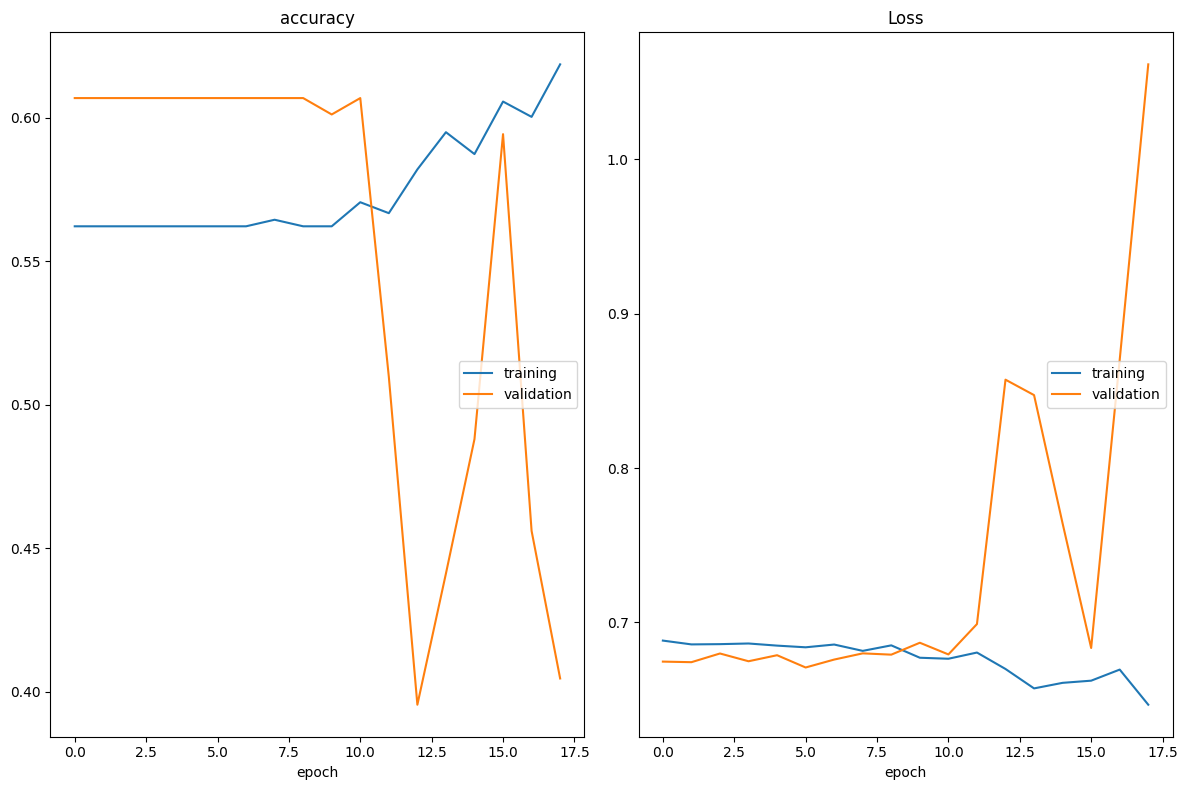

accuracy
	training         	 (min:    0.562, max:    0.619, cur:    0.619)
	validation       	 (min:    0.395, max:    0.607, cur:    0.405)
Loss
	training         	 (min:    0.647, max:    0.688, cur:    0.647)
	validation       	 (min:    0.671, max:    1.062, cur:    1.062)


In [ ]:
model.fit(X_train, y_train,
                    epochs=1000,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    callbacks=[early_stopping, model_checkpoint, plot_losses],
                    verbose=False)



# plot val and train accuracy

In [ ]:
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.title('Training and Validation Accuracy')
# plt.legend()
# plt.show()


#plot model architecture

In [ ]:
# plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)



In [ ]:
# print(model.summary())